In [1]:
import cell2fate as c2f
import scanpy as sc
import scvelo as scv
import numpy as np

Global seed set to 0


We use the same pancreas dataset as in the scvelo and cellrank tutorials:

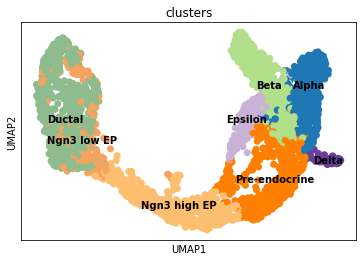

In [17]:
adata = scv.datasets.pancreas()
sc.pl.umap(adata, color = 'clusters', s = 200, legend_loc='on data')

To fit our model we choose the 2000 most variable genes that have at least 20 counts across all cells (this is also identical to the scvelo and cellrank tutorials).

In [3]:
adata = c2f.utils.get_training_data(adata,
                remove_clusters = [],
                                    cells_per_cluster = 10**6, cluster_column = 'clusters',
                                    min_shared_counts = 20, n_var_genes = 2000)

Keeping at most 1000000 cells per cluster
Filtered out 20801 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.


We register the anndata object and create the model instance as with other scvi-tools methods:

In [4]:
c2f.Cell2fate_MultiLineage.setup_anndata(adata)

In [5]:
max_lineages = 4
mod = c2f.Cell2fate_MultiLineage(adata, n_lineages = max_lineages)

Ideally, the max_lineages parameter can be larger than the real number of lineages, which is only 4 in this dataset (Alpha, Beta, Delta, Epsilon) and then our method should 'switch off' (assign low probability) to lineages that are not needed. But at this point our models are not good enough to do that well and the best results are obtained when the max_lineages parameter corresponds to the actual number of lineages in the data.

In [6]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.15.5.

Setup via `Cell2fate_MultiLineage.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced'
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 3696  │
│      n_vars      │ 2000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

The lower the learning rate and the higher the number of iterations, the better the results. For example a learning rate of 0.001 and 100000 iterations will give slightly better results than here and a learning rate 0.1 and just 100 iterations will give slightly worse results, but has the upside of a very short training time.

In [7]:
max_epochs = 10000
mod.train(use_gpu=True, batch_size = None, max_epochs = max_epochs, lr = 0.005)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10000/10000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [23:14<00:00,  7.17it/s, v_num=1, elbo_train=8.61e+6]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

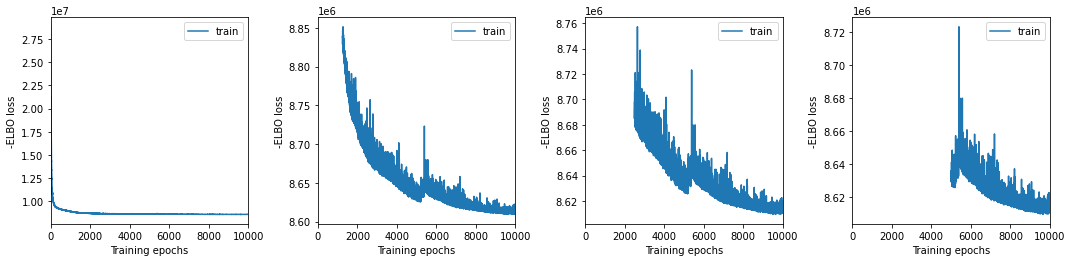

In [8]:
mod.view_history()

Here we export the model posterior to the anndata object and calculate some useful quantities like RNAvelocity based on it. We use 10 posterior samples. Lower number of samples will take up less memory, but will also result in less accurate expectation values (mean) and uncertainty values (standard deviation) for each parameter. In general I find that at least 3 samples are needed for accurate mean values and 10 for accurate standard deviation, but of course this depends on how much uncertainty there is in a parameter.

In [9]:
adata = mod.export_posterior(adata,
                 sample_kwargs = {"num_samples": 10, "batch_size" : adata.n_obs,
                                  "use_gpu" : True, 'return_samples': True},
                 full_velocity_posterior = True)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.64it/s]
Computing lineage probabilities based on posterior of lineage specific mean and variance.
Computing RNAvelocity based on posterior of rates and latent time.
Computing normalized counts based on posterior of technical variables.


Inferred latent time looks very accurate:

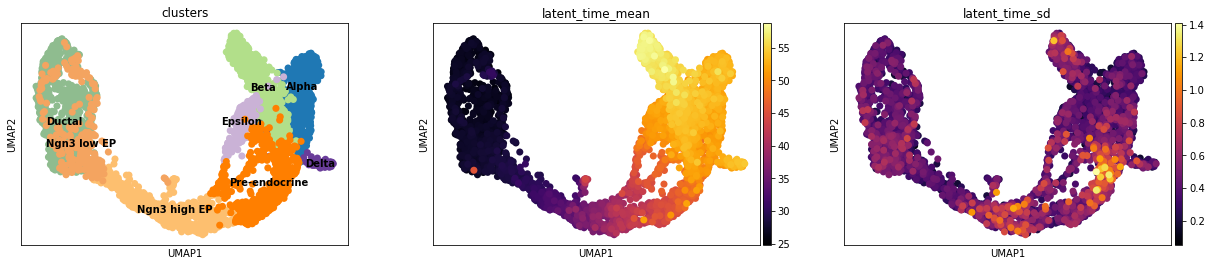

In [10]:
sc.pl.umap(adata, color = ['clusters', 'latent_time_mean', 'latent_time_sd'], legend_loc = 'on data',
            size = 200, color_map = 'inferno')

Inferred lineages are not very accurate, but we are working to improve this.

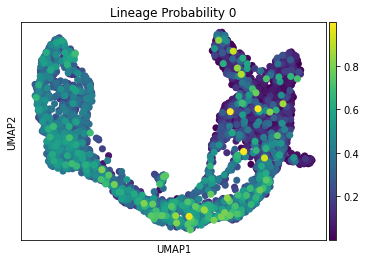

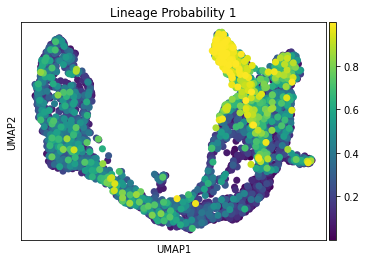

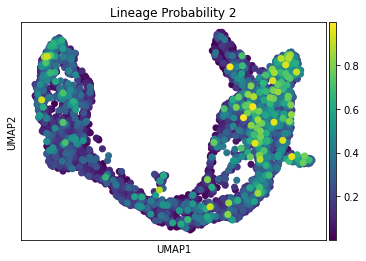

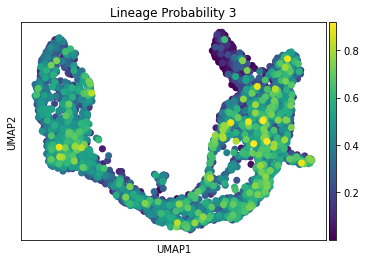

In [13]:
for i in range(max_lineages):
    sc.pl.umap(adata, color = ['Lineage Probability ' + str(i)], legend_loc = 'right column',
                size = 200, color_map = 'viridis')

We can also use the method in the original scvelo paper to visualize RNAvelocity with arrows on a UMAP:

Using full velocity posterior to calculate velocity graph
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


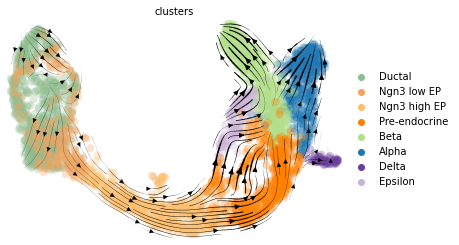

In [12]:
c2f.utils.plot_velocity_umap_Bergen2020(adata, use_full_posterior = True,
                              plotting_kwargs = {"color": 'clusters', 'legend_fontsize': 10, 'legend_loc': 'right_margin'})